In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# General analysis packages
import numpy as np
import pandas as pd
import math

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import PowerTransformer, RobustScaler 
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#Model making
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.metrics import AUC
from scipy.interpolate import interp1d
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LeakyReLU

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# Load and Prepare Dataset

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv',index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv',index_col='id')
target = 'rainfall'

print(f'Traning data shape: {train_data.shape}')
print(f'Testing data shape: {test_data.shape}')

# temperature is misspelled; fixing that
train_data.rename(columns={"temparature": "temperature"}, inplace=True)
test_data.rename(columns={"temparature": "temperature"}, inplace=True)



# split target from training data
target_data = train_data[target].copy()
train_data.drop(target,axis=1,inplace=True)

# combine training and testing data for ease of data exploration and feature engineering
combo_data = pd.concat([train_data,test_data])

# Fix time series by replacing 'day', which has errors, with 'expected_day'
# Seems to perform better with expected_day
combo_data['expected_day'] = (combo_data.index) % 365 + 1
combo_data.drop('day',axis=1,inplace=True)

# Use cyclical encoding for the day
combo_data['day_sin'] = np.sin(2*3.14159*combo_data['expected_day']/365)
combo_data['day_cos'] = np.cos(2*3.14159*combo_data['expected_day']/365)
#combo_data.drop('expected_day',axis=1,inplace=True)

index_split = int(2190)

Traning data shape: (2190, 12)
Testing data shape: (730, 11)


# Explore Data

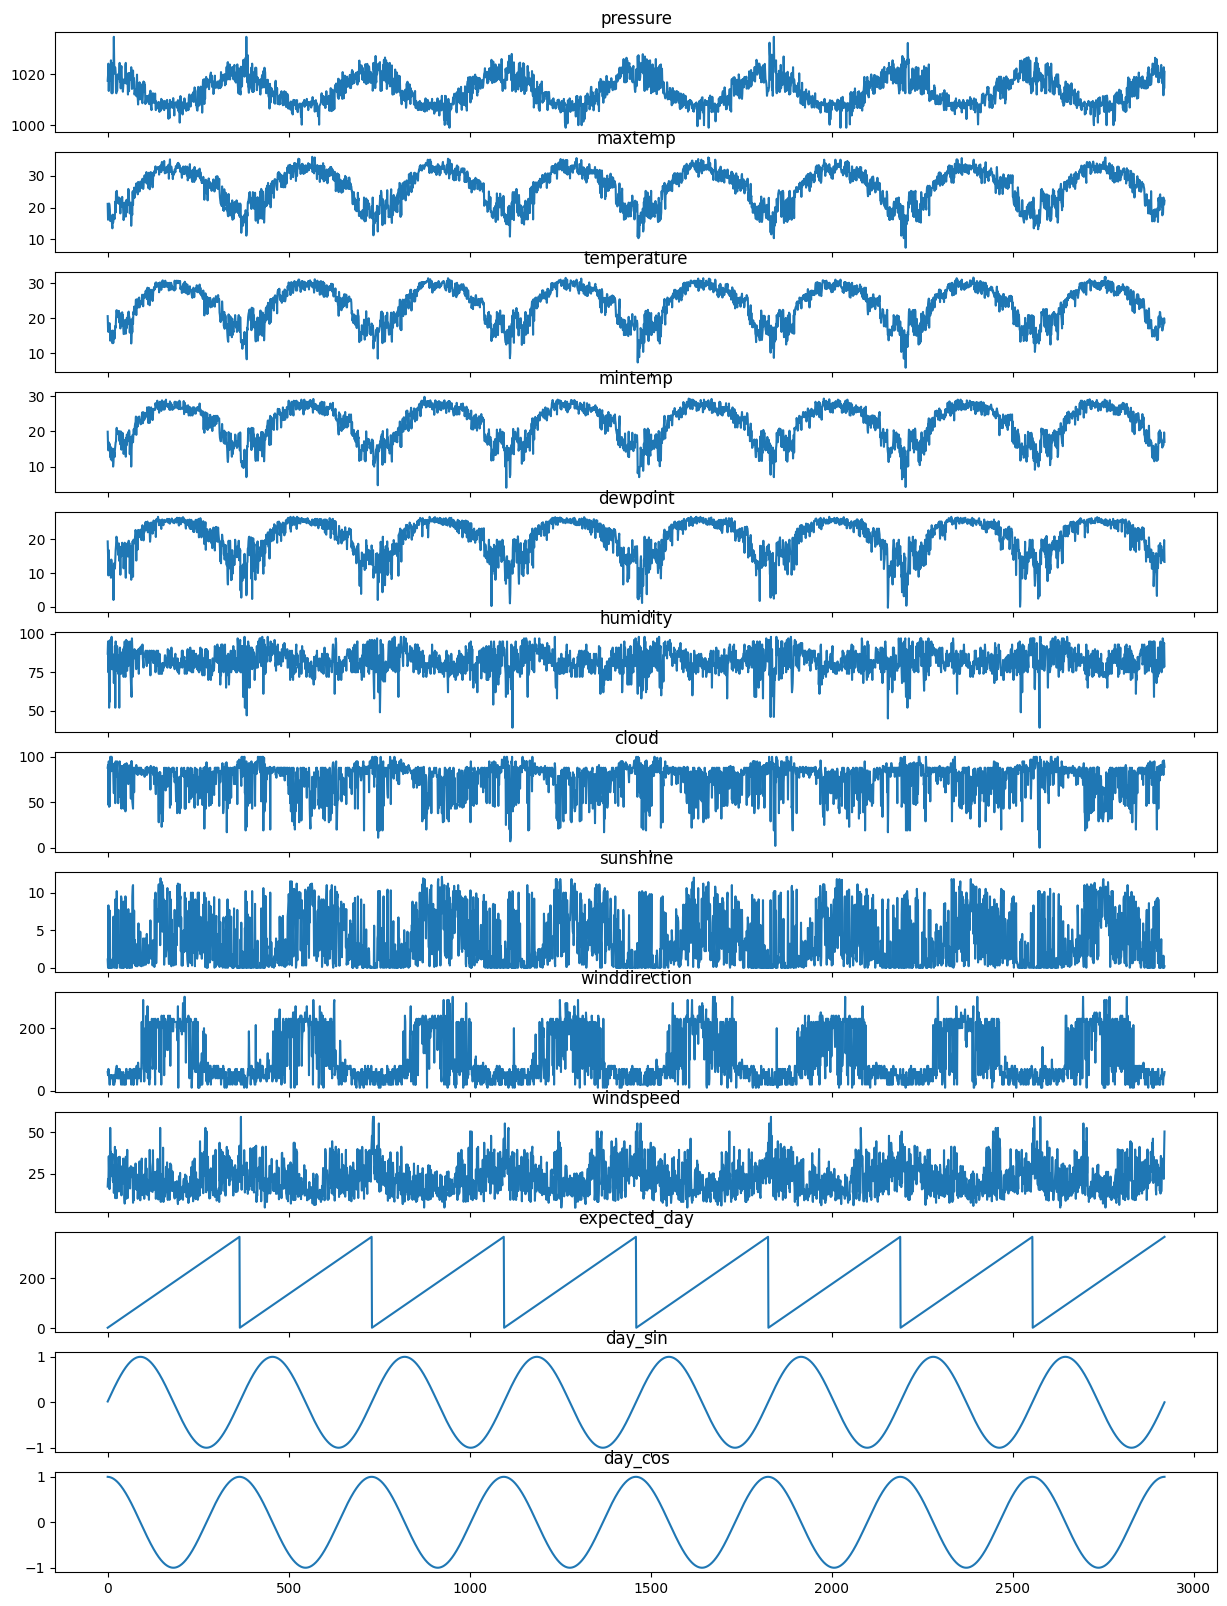

In [3]:
# Plot all features as a function of the index
def plot_vs_index(df):
    fig, axes = plt.subplots(len(df.columns), 1, figsize=(15, 20), sharex=True)
    i = 0
    for col in df.columns:
        axes[i].plot(df[col])
        axes[i].set_title(str(col))
        i = i+1

plot_vs_index(combo_data)

In [4]:
combo_data.head()

pressure  maxtemp  temperature  mintemp  dewpoint  humidity  cloud  \
id                                                                       
0     1017.4     21.2         20.6     19.9      19.4      87.0   88.0   
1     1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
2     1024.1     19.4         16.1     14.6       9.3      75.0   47.0   
3     1013.4     18.1         17.8     16.9      16.8      95.0   95.0   
4     1021.8     21.3         18.4     15.2       9.6      52.0   45.0   

    sunshine  winddirection  windspeed  expected_day   day_sin   day_cos  
id                                                                        
0        1.1           60.0       17.2             1  0.017213  0.999852  
1        0.0           50.0       21.9             2  0.034422  0.999407  
2        8.3           70.0       18.1             3  0.051620  0.998667  
3        0.0           60.0       35.6             4  0.068802  0.997630  
4        3.6           40.0       24.8             5  0.085965  0.996298

In [5]:
print(f'Null values:\n{combo_data.isnull().sum()}')

Null values:
pressure         0
maxtemp          0
temperature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
expected_day     0
day_sin          0
day_cos          0
dtype: int64


In [6]:
combo_data.fillna(0, inplace=True)
print(f'Null values:\n{combo_data.isnull().sum()}')

Null values:
pressure         0
maxtemp          0
temperature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
expected_day     0
day_sin          0
day_cos          0
dtype: int64


I overlooked it in the previous cells, but there is a single null value for winddirection in the testing dataset. It's only a single value, so it won't have  large effect. 

Number of features to plot = 13


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

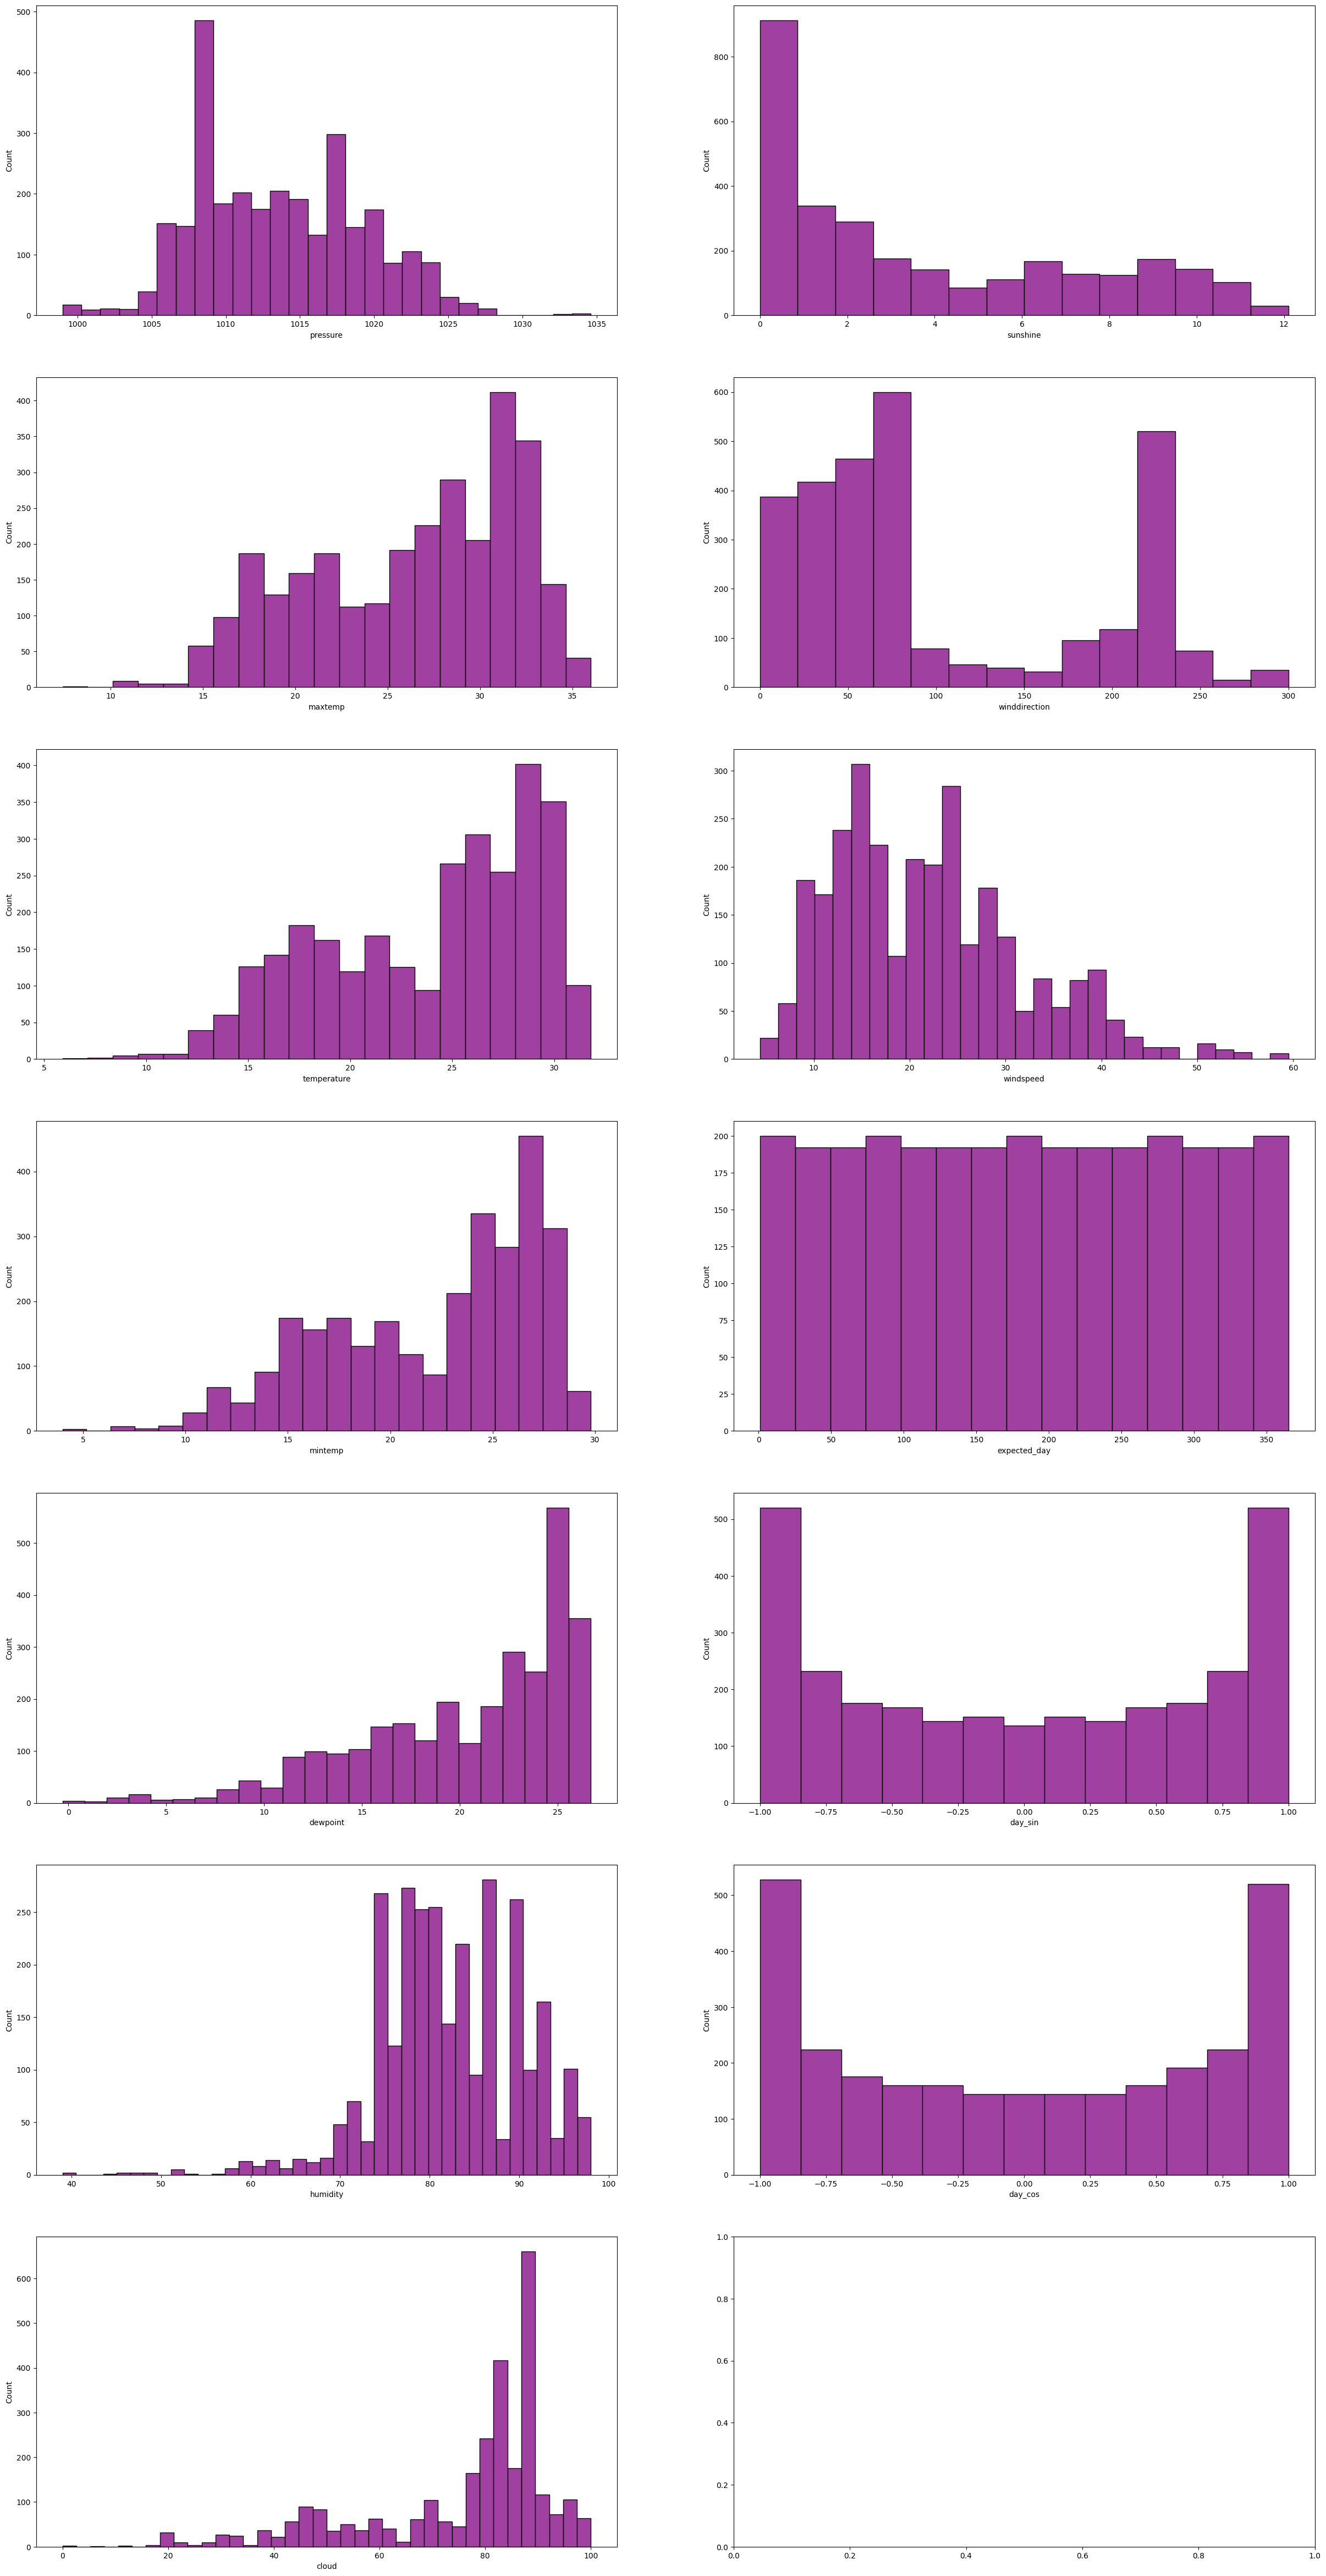

In [7]:
# Plot feature distributions
def plot_feature_distributions(df):
    num_features = len(df.columns)
    print(f'Number of features to plot = {num_features}')
    
    ncols = 2
    nrows = math.ceil(num_features/2)
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=(30,60))
    for i, feature in enumerate(df.columns):
        sns.histplot(data=df, x=feature, ax=axes[i%nrows,i//nrows], color='purple')

plot_feature_distributions(combo_data)

Some data is skewed; will take care of this later

Percentage of ones in training data: 75.34 %


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


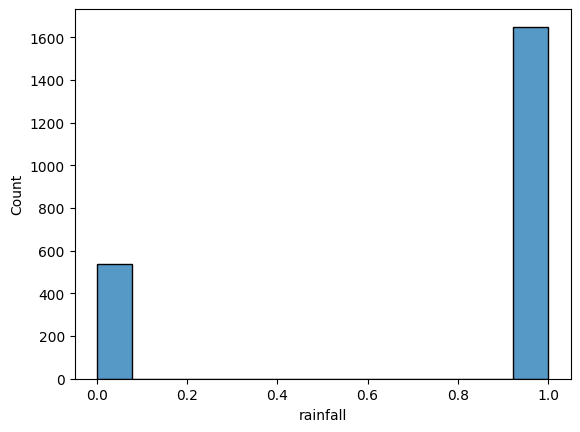

In [8]:
# Plot target distribution
sns.histplot(data=target_data)
print(f'Percentage of ones in training data: {round(100*((target_data.sum())/len(target_data)),2)} %')

This is a binary problem, and there are far more ones than zeroes in this dataset. I read about how to handle this situation in the statistical learning book I'm reading, so I'll go back and look into that. I think the issue is that a very simple model which always predicts 1.0 will be right 75% of the time on this dataset, so this needs to be accounted for.

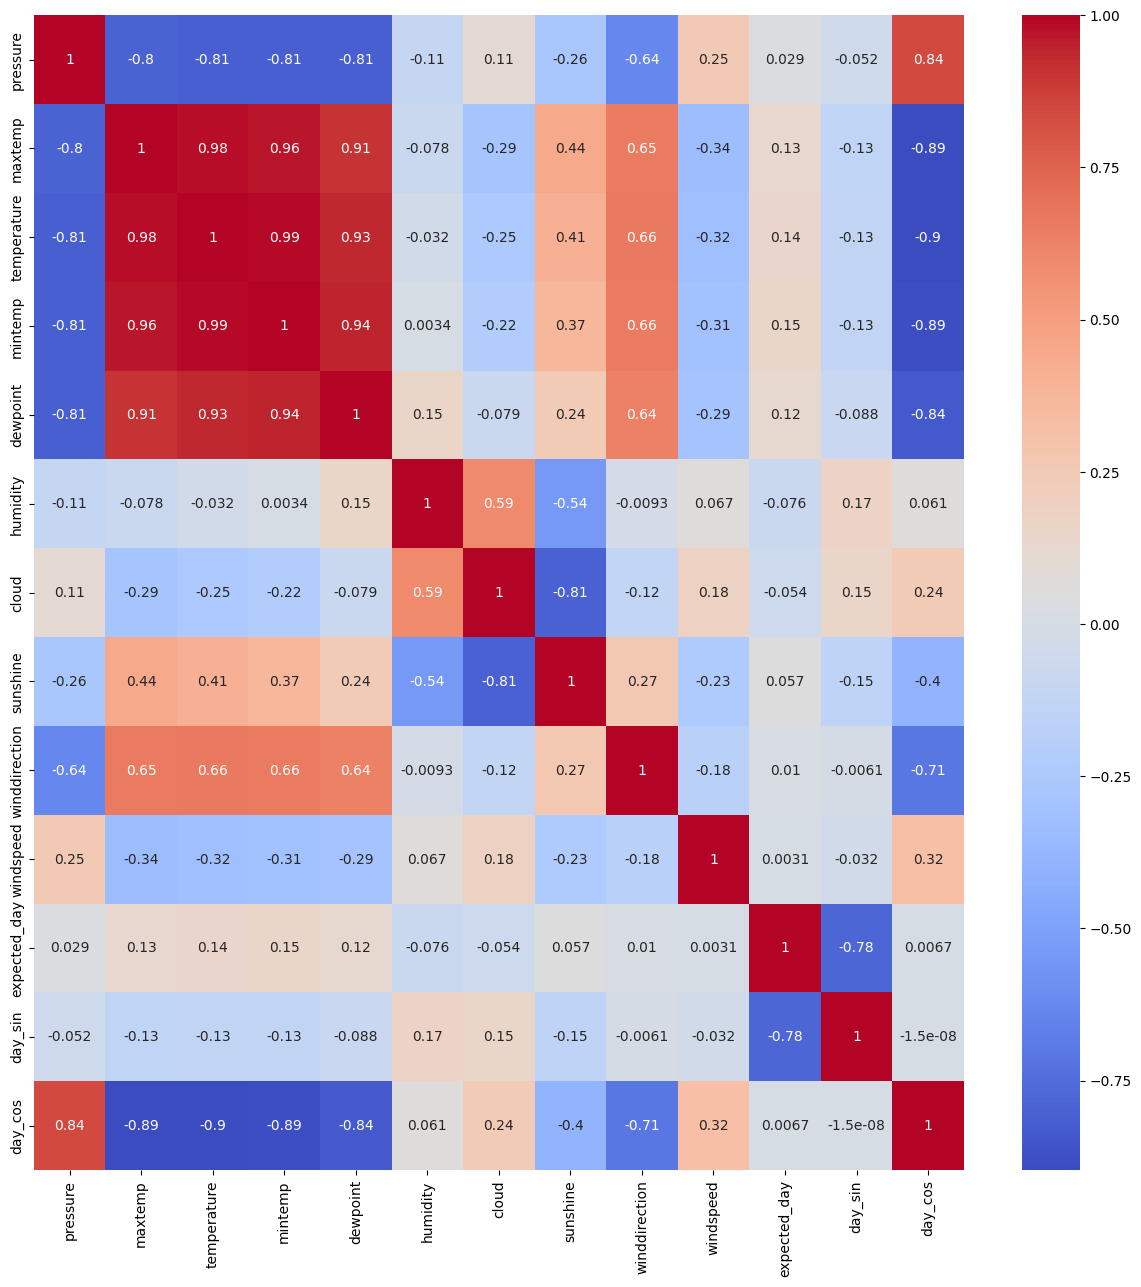

In [9]:
# Make a plot of correlations between features
def plot_correlations(df):
    corr_data = df.corr(method='pearson')  # Get the correlation matrix
    
    plt.figure(figsize=(15,15))
    sns.heatmap(data=corr_data, cmap='coolwarm', annot=True, fmt='.2g')
    
plot_correlations(combo_data)

* temperature variables are strongly correlated with dewpoint
* pressure is strongly correlated with temperature

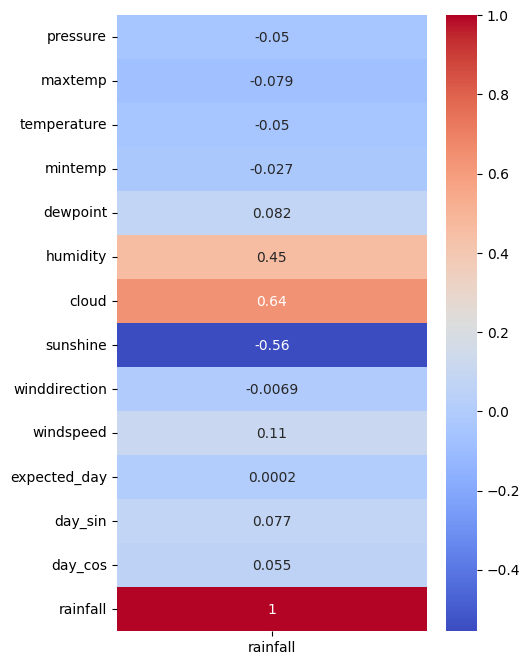

In [10]:
# Correlation with the target
def plot_target_correlations(df):
    tmp_data = df.reset_index(drop=True).iloc[:index_split].copy()
    tmp_data[target] = target_data
    
    corr_data = tmp_data.corr(method='pearson').copy()
    corr_data = corr_data[[target]]
    
    plt.figure(figsize=(5,8))
    sns.heatmap(data=corr_data, cmap='coolwarm', annot=True, fmt='.2g')

plot_target_correlations(combo_data)

Winddirection has very little correlation to the target. It will be dropped later on.

In [11]:
def plot_MI(df):
    tmp_data = df.reset_index(drop=True).iloc[:index_split].copy()
    tmp_data[target] = target_data
    mi = mutual_info_regression(tmp_data, target_data)
    features = tmp_data.columns
    mi_dict = dict(zip(features, mi))
    plt.figure(figsize=(35, 10),dpi=500)
    plt.bar(features, mi, color='skyblue')
    plt.title('Mutual Information Between Features and Target')
    plt.xlabel('Features')
    plt.ylabel('Mutual Information')
    plt.show()

    for key, value in mi_dict.items():
        print(f"{key}: {value}")
    return mi_dict
plot_MI(combo_data)

pressure: 0.006360222828293516
maxtemp: 0.03999228790353193
temperature: 0.043353405899638986
mintemp: 0.03838502837186297
dewpoint: 0.037104498665494035
humidity: 0.14663481698448422
cloud: 0.19952134759955342
sunshine: 0.14433110793378212
winddirection: 0.0
windspeed: 0.0
expected_day: 0.07072984201779864
day_sin: 0.057410252646457494
day_cos: 0.06471407811246799
rainfall: 0.5701628105047369


{'pressure': 0.006360222828293516,
 'maxtemp': 0.03999228790353193,
 'temperature': 0.043353405899638986,
 'mintemp': 0.03838502837186297,
 'dewpoint': 0.037104498665494035,
 'humidity': 0.14663481698448422,
 'cloud': 0.19952134759955342,
 'sunshine': 0.14433110793378212,
 'winddirection': 0.0,
 'windspeed': 0.0,
 'expected_day': 0.07072984201779864,
 'day_sin': 0.057410252646457494,
 'day_cos': 0.06471407811246799,
 'rainfall': 0.5701628105047369}

Looking at how each feature affects the target, it seems like most features can simply be dropped. Will try dropping all except for humidity, cloud, sunshine, and day_sin, day_cos to see how it goes

# Feature Engineering

In [12]:
# To deal with the strong correlation between dewpoint and temperature, I will create a new feature called 'dewpointdepression'
print(f'Before: {combo_data.columns}')
def combine_dewpoint_temp(df):
    new_col = 'dewpointdepression'
    df[new_col] = df['temperature'] - df['dewpoint']
    df.drop('temperature',axis=1,inplace=True)
    df.drop('dewpoint',axis=1,inplace=True)
    return df

def transform_temp(df):
    df['temp_spread'] = df['maxtemp']-df['mintemp']
    df.drop('maxtemp',axis=1,inplace=True)
    df.drop('mintemp',axis=1,inplace=True)
    return df

combo_data = transform_temp(combo_data)
combo_data = combine_dewpoint_temp(combo_data)

print(f'After: {combo_data.columns}')

Before: Index(['pressure', 'maxtemp', 'temperature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'winddirection', 'windspeed', 'expected_day',
       'day_sin', 'day_cos'],
      dtype='object')
After: Index(['pressure', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'expected_day', 'day_sin', 'day_cos', 'temp_spread',
       'dewpointdepression'],
      dtype='object')


In [13]:
# Combine sunshine and cloud features since they are negatively correlated
combo_data['sun-cloud ratio'] = combo_data['sunshine']/np.log1p(combo_data['cloud']+1)

In [14]:
# add some lag features
def add_lag(df,lag_name,feature,n_shift):
    df[lag_name] = df[feature].shift(n_shift)
    df.reindex()
    df.fillna(0, inplace=True)

for col in combo_data.columns:
    for lag in range(5):
        lag_name = f'{col}_lag_{lag}'
        add_lag(combo_data,lag_name,col,lag+1)

combo_data.head()

pressure  humidity  cloud  sunshine  winddirection  windspeed  \
id                                                                  
0     1017.4      87.0   88.0       1.1           60.0       17.2   
1     1019.5      95.0   91.0       0.0           50.0       21.9   
2     1024.1      75.0   47.0       8.3           70.0       18.1   
3     1013.4      95.0   95.0       0.0           60.0       35.6   
4     1021.8      52.0   45.0       3.6           40.0       24.8   

    expected_day   day_sin   day_cos  temp_spread  dewpointdepression  \
id                                                                      
0              1  0.017213  0.999852          1.3                 1.2   
1              2  0.034422  0.999407          0.4                 1.5   
2              3  0.051620  0.998667          4.8                 6.8   
3              4  0.068802  0.997630          1.2                 1.0   
4              5  0.085965  0.996298          6.1                 8.8   

    sun-cloud ratio  pressure_lag_0  pressure_lag_1  pressure_lag_2  \
id                                                                    
0          0.244455             0.0             0.0             0.0   
1          0.000000          1017.4             0.0             0.0   
2          2.132678          1019.5          1017.4             0.0   
3          0.000000          1024.1          1019.5          1017.4   
4          0.935029          1013.4          1024.1          1019.5   

    pressure_lag_3  pressure_lag_4  humidity_lag_0  humidity_lag_1  \
id                                                                   
0              0.0             0.0             0.0             0.0   
1              0.0             0.0            87.0             0.0   
2              0.0             0.0            95.0            87.0   
3              0.0             0.0            75.0            95.0   
4           1017.4             0.0            95.0            75.0   

    humidity_lag_2  humidity_lag_3  humidity_lag_4  cloud_lag_0  cloud_lag_1  \
id                                                                             
0              0.0             0.0             0.0          0.0          0.0   
1              0.0             0.0             0.0         88.0          0.0   
2              0.0             0.0             0.0         91.0         88.0   
3             87.0             0.0             0.0         47.0         91.0   
4             95.0            87.0             0.0         95.0         47.0   

    cloud_lag_2  cloud_lag_3  cloud_lag_4  sunshine_lag_0  sunshine_lag_1  \
id                                                                          
0           0.0          0.0          0.0             0.0             0.0   
1           0.0          0.0          0.0             1.1             0.0   
2           0.0          0.0          0.0             0.0             1.1   
3          88.0          0.0          0.0             8.3             0.0   
4          91.0         88.0          0.0             0.0             8.3   

    sunshine_lag_2  sunshine_lag_3  sunshine_lag_4  winddirection_lag_0  \
id                                                                        
0              0.0             0.0             0.0                  0.0   
1              0.0             0.0             0.0                 60.0   
2              0.0             0.0             0.0                 50.0   
3              1.1             0.0             0.0                 70.0   
4              0.0             1.1             0.0                 60.0   

    winddirection_lag_1  winddirection_lag_2  winddirection_lag_3  \
id                                                                  
0                   0.0                  0.0                  0.0   
1                   0.0                  0.0                  0.0   
2                  60.0                  0.0                  0.0   
3                  50.0                 60.0   

In [15]:
# How skewed is the data?
data_skew = combo_data.skew().sort_values(ascending=False)

print(data_skew)

sun-cloud ratio             1.772882e+00
sun-cloud ratio_lag_1       1.772815e+00
sun-cloud ratio_lag_2       1.772815e+00
sun-cloud ratio_lag_0       1.772815e+00
sun-cloud ratio_lag_3       1.772473e+00
sun-cloud ratio_lag_4       1.772473e+00
dewpointdepression          1.257309e+00
dewpointdepression_lag_0    1.256356e+00
dewpointdepression_lag_1    1.255891e+00
dewpointdepression_lag_2    1.253349e+00
dewpointdepression_lag_3    1.250759e+00
dewpointdepression_lag_4    1.248697e+00
windspeed                   7.662722e-01
windspeed_lag_0             7.608737e-01
windspeed_lag_1             7.586527e-01
windspeed_lag_2             7.553066e-01
windspeed_lag_3             7.523559e-01
windspeed_lag_4             7.502752e-01
winddirection               7.141164e-01
winddirection_lag_0         7.136806e-01
winddirection_lag_1         7.132232e-01
winddirection_lag_2         7.127669e-01
winddirection_lag_3         7.123213e-01
winddirection_lag_4         7.120096e-01
sunshine        

I'm going to transform variables that have a |skew|>1. In this case, that is dewpoint and cloud

In [16]:
# Transform all features with a |skew| > 1
cols_to_transform = []
for key, value in data_skew.items():
    if math.fabs(value) > 1:
        cols_to_transform.append(key)
        
for col in cols_to_transform:
    yeo_johnson = PowerTransformer(method='yeo-johnson',standardize=True,copy=True)
    combo_data[[col]] = yeo_johnson.fit_transform(combo_data[[col]])

In [17]:
# Normalization
# Robust scaling
robust_data = RobustScaler()
robust_data.fit(combo_data)

combo_data_norm = robust_data.transform(combo_data)

# RobustScalar turns the dataframe into a numpy array
# Turn it back into a pandas dataframe
combo_data_norm = pd.DataFrame(combo_data_norm,columns=combo_data.columns)

Number of features to plot = 72


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

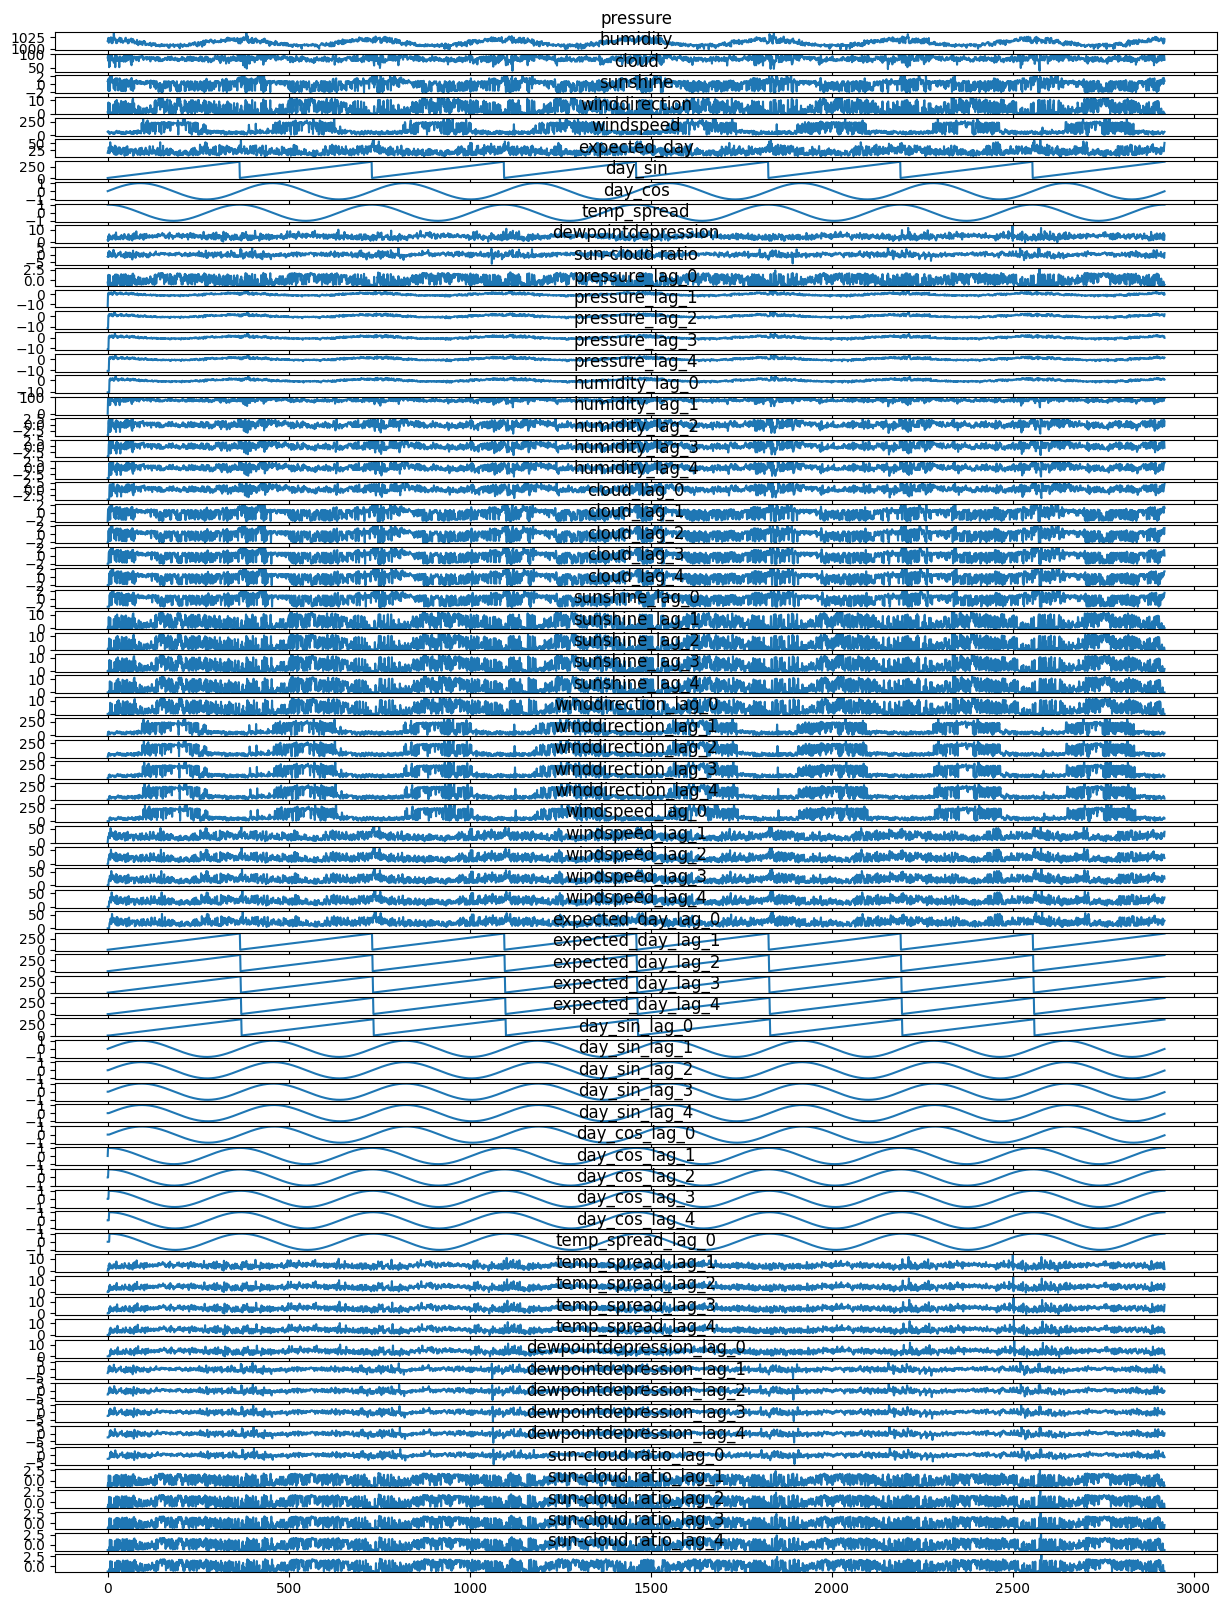

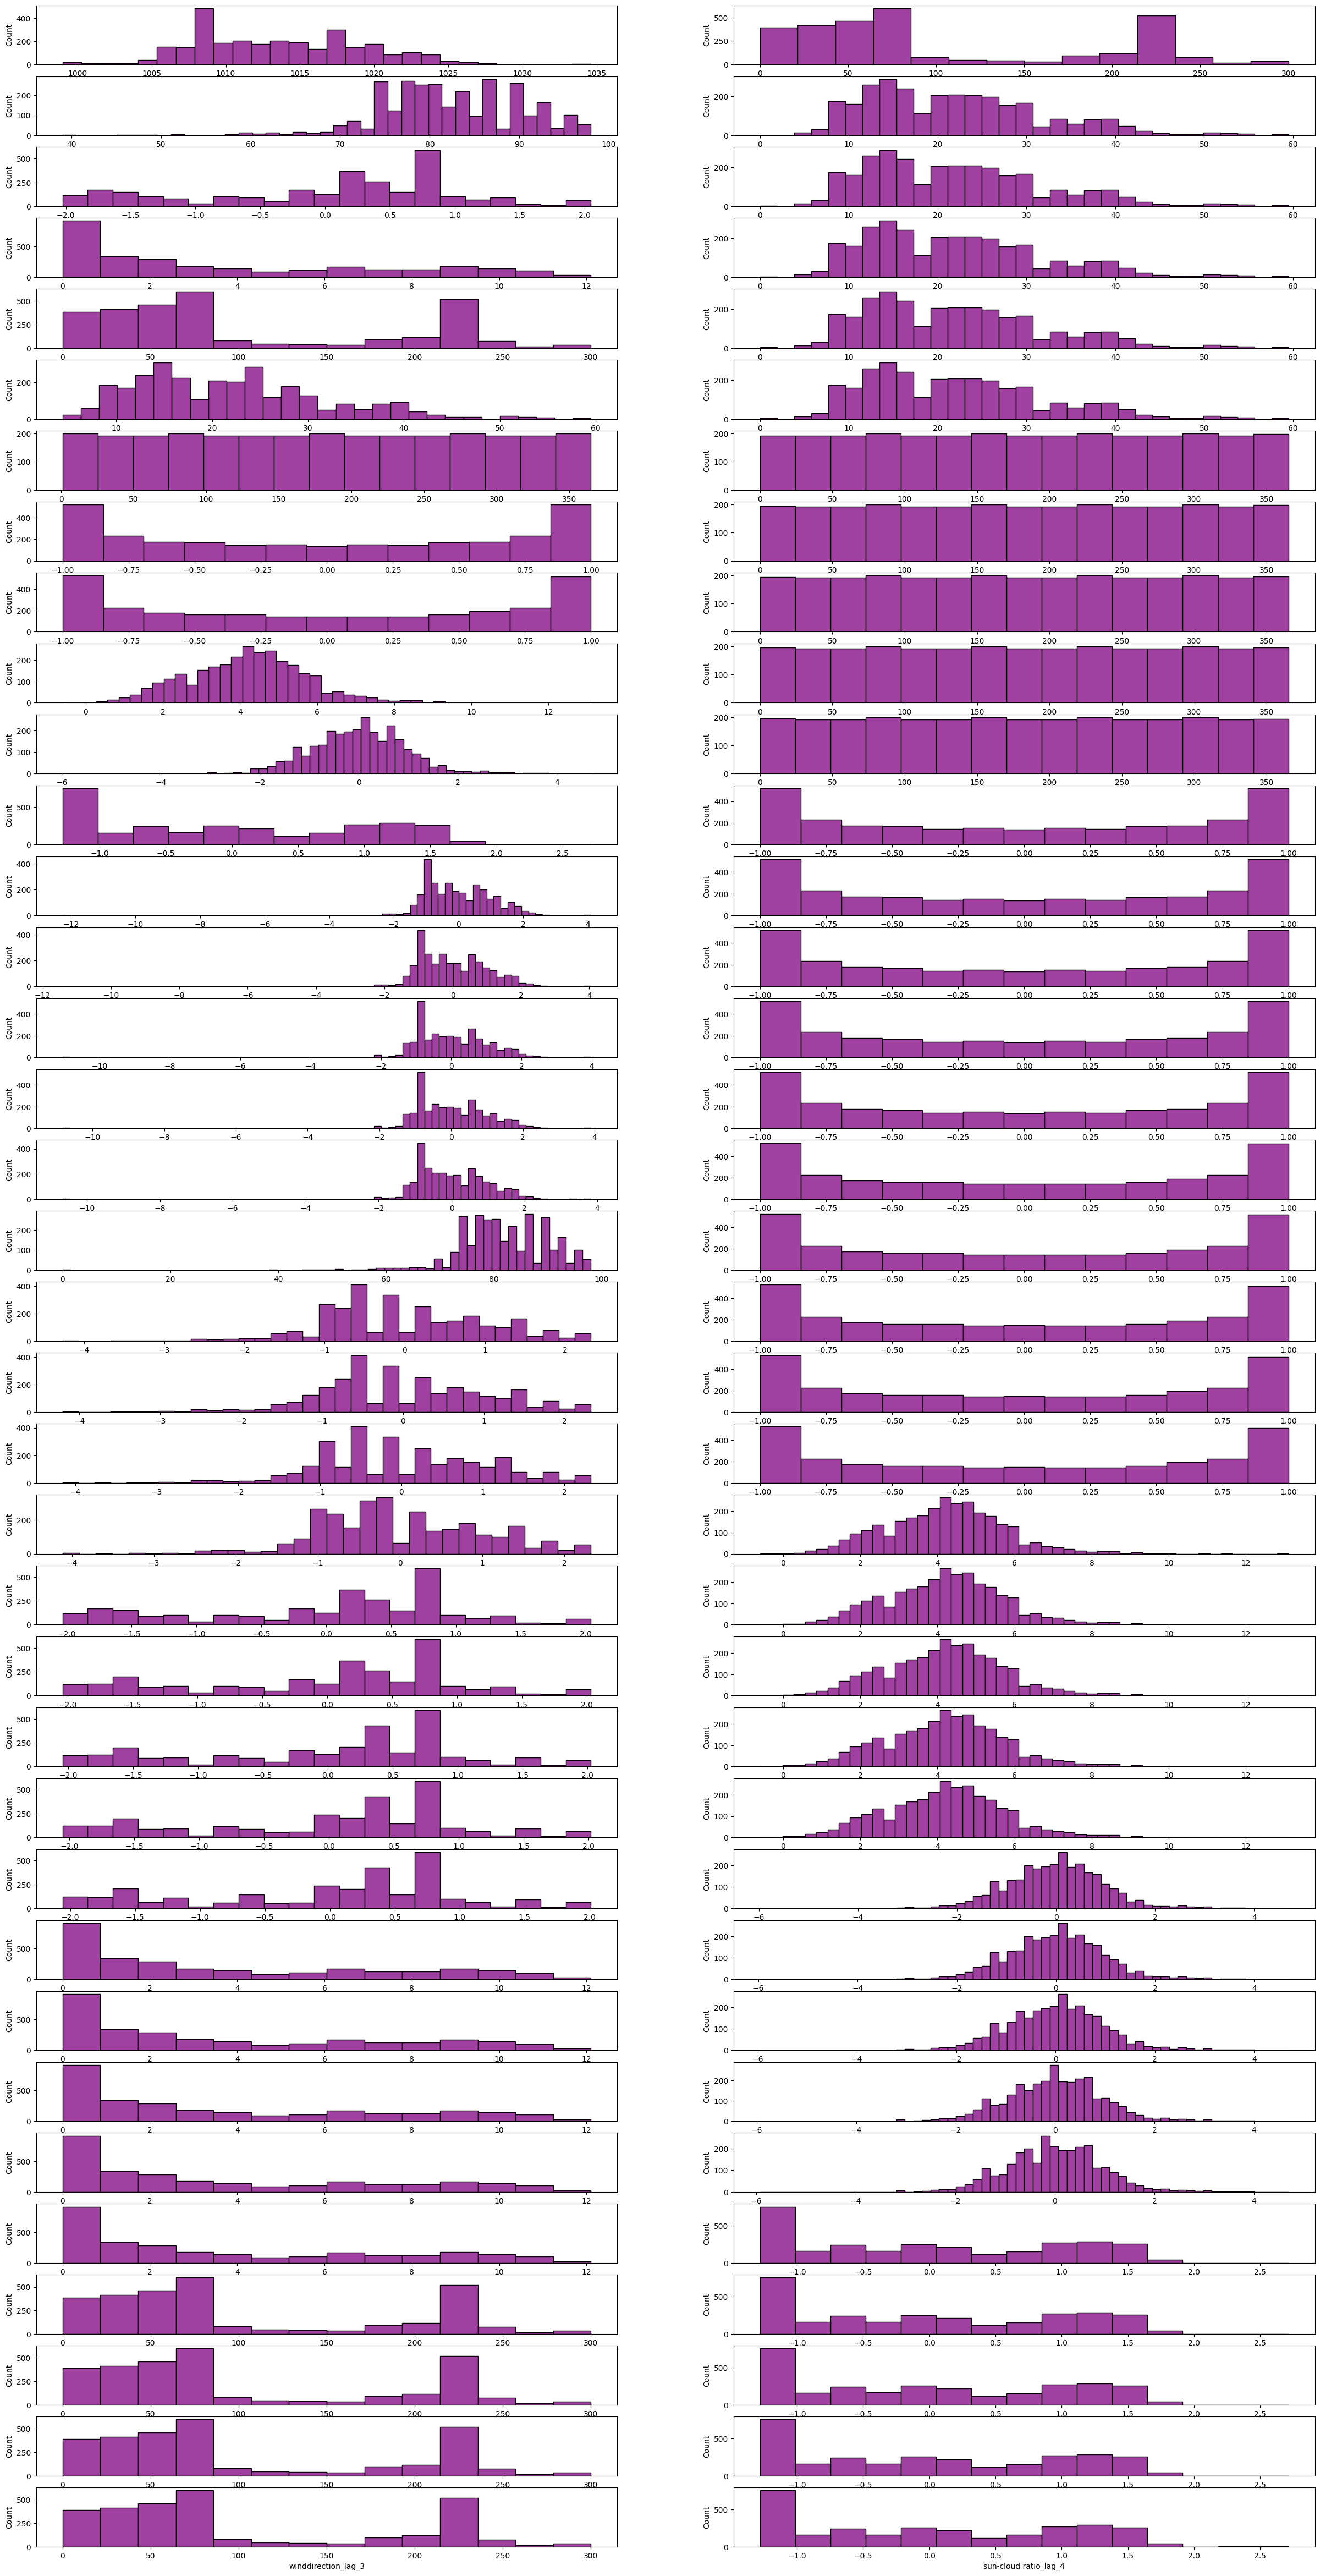

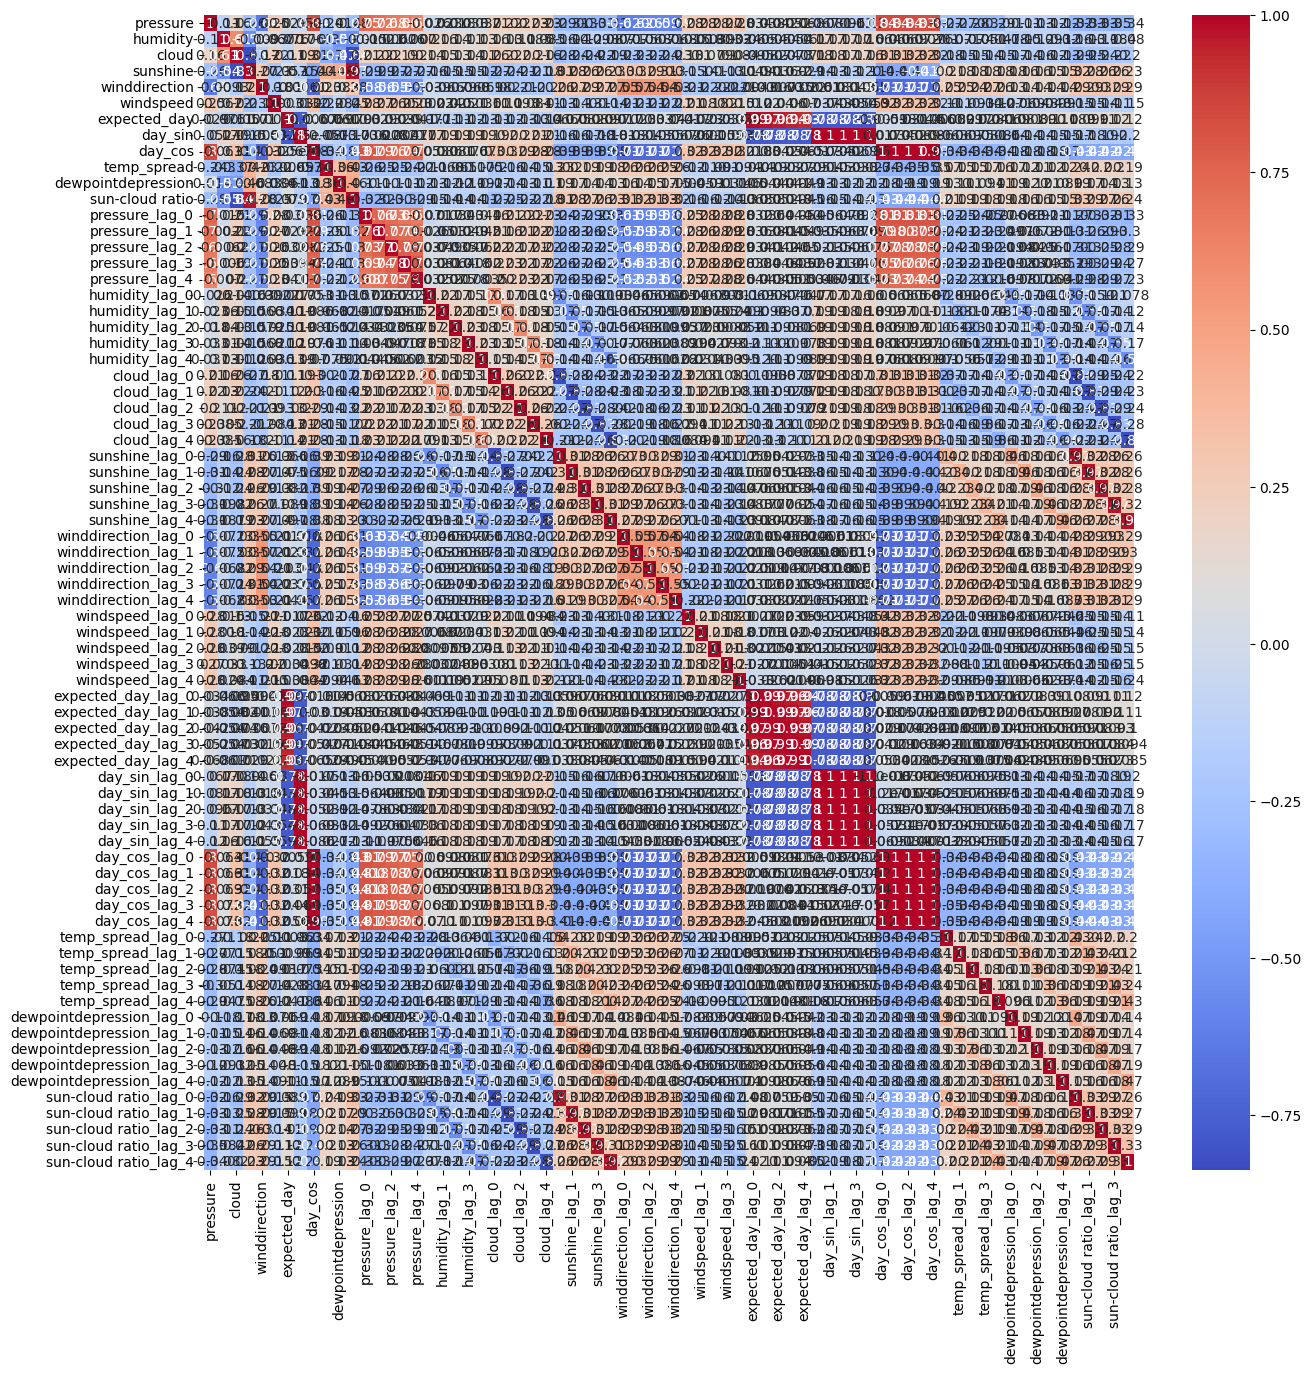

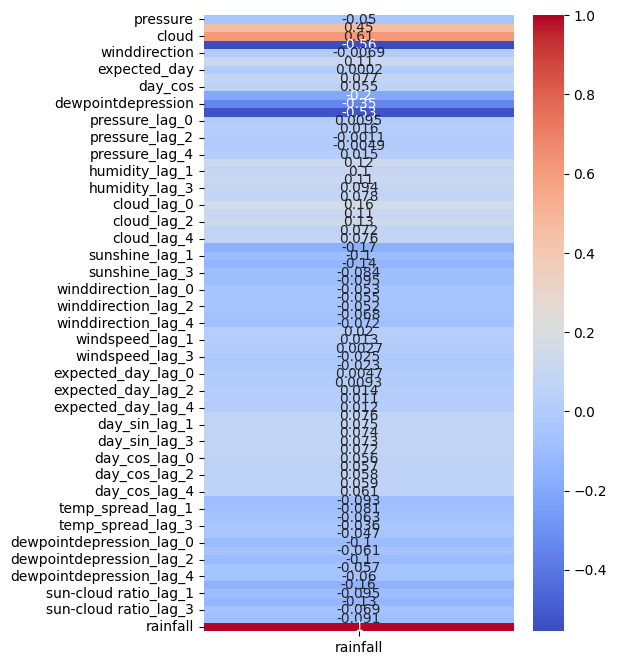

pressure: 0.02053796075970027
humidity: 0.1254547622509179
cloud: 0.21350053746428088
sunshine: 0.1622601596891151
winddirection: 0.013721794557070233
windspeed: 0.0019647154797581834
expected_day: 0.07420119789377111
day_sin: 0.0698616858423815
day_cos: 0.06339605463950004
temp_spread: 0.03465901484708578
dewpointdepression: 0.09612062004877941
sun-cloud ratio: 0.16422990799512327
pressure_lag_0: 0.0
pressure_lag_1: 0.0
pressure_lag_2: 0.0
pressure_lag_3: 0.021404996752007577
pressure_lag_4: 0.0
humidity_lag_0: 0.028565794095910313
humidity_lag_1: 0.013399078540945908
humidity_lag_2: 0.0
humidity_lag_3: 0.0
humidity_lag_4: 0.0
cloud_lag_0: 0.010595083124226079
cloud_lag_1: 0.014246949266251363
cloud_lag_2: 0.029894076069904685
cloud_lag_3: 0.020552254062140562
cloud_lag_4: 0.0
sunshine_lag_0: 0.008281197979901123
sunshine_lag_1: 0.0028204937102067618
sunshine_lag_2: 0.008630127556779499
sunshine_lag_3: 0.013151309796723964
sunshine_lag_4: 0.0074526964574141985
winddirection_lag_0: 0.0

In [18]:
# make new plots after all features have been chosen and transformed
plot_vs_index(combo_data)
plot_feature_distributions(combo_data)
plot_correlations(combo_data)
plot_target_correlations(combo_data)
mi_dict = plot_MI(combo_data)

In [19]:
# # Create Fourier Features
# fourier_year = CalendarFourier(freq='YE', order=10)

# combo_data['date'] = pd.to_datetime(combo_data['expected_day'], format='%j', errors='coerce')  # Convert to fake date
# combo_data = combo_data.set_index('date')

# # Generate seasonal features
# dp = DeterministicProcess(
#     index=combo_data.index,
#     constant=True,
#     order=1,  # Linear trend
#     additional_terms=[fourier],
#     drop=True
# )

# seasonal_features = dp.in_sample()
# combo_data = combo_data.join(seasonal_features)

# Model Training

In [20]:
# Split testing and training data once again
X = combo_data_norm.iloc[:index_split].copy()
X_test = combo_data_norm.iloc[index_split:].copy()
y = target_data.copy()

print(f'Length of training dataframe: {len(X)}')
print(f'Length of target dataframe: {len(y)}')
print(f'Features to train on: \n{combo_data.columns}')
print(f'Number of features: {len(combo_data.columns)}')
print(type(X))
print(type(X_test))
print(type(y))

Length of training dataframe: 2190
Length of target dataframe: 2190
Features to train on: 
Index(['pressure', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'expected_day', 'day_sin', 'day_cos', 'temp_spread',
       'dewpointdepression', 'sun-cloud ratio', 'pressure_lag_0',
       'pressure_lag_1', 'pressure_lag_2', 'pressure_lag_3', 'pressure_lag_4',
       'humidity_lag_0', 'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3',
       'humidity_lag_4', 'cloud_lag_0', 'cloud_lag_1', 'cloud_lag_2',
       'cloud_lag_3', 'cloud_lag_4', 'sunshine_lag_0', 'sunshine_lag_1',
       'sunshine_lag_2', 'sunshine_lag_3', 'sunshine_lag_4',
       'winddirection_lag_0', 'winddirection_lag_1', 'winddirection_lag_2',
       'winddirection_lag_3', 'winddirection_lag_4', 'windspeed_lag_0',
       'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3',
       'windspeed_lag_4', 'expected_day_lag_0', 'expected_day_lag_1',
       'expected_day_lag_2', 'expected_day_lag_3', 'expec

In [21]:
# # drop features with smallest affect

features_to_drop = []
for key, value in mi_dict.items():
    if value < 0.06:
        features_to_drop.append(key)

print(f'Number of features to drop: {len(features_to_drop)}')
print(f'Features to drop:\n{features_to_drop}')
X.drop(features_to_drop,axis=1,inplace=True)
X_test.drop(features_to_drop,axis=1,inplace=True)

Number of features to drop: 54
Features to drop:
['pressure', 'winddirection', 'windspeed', 'temp_spread', 'pressure_lag_0', 'pressure_lag_1', 'pressure_lag_2', 'pressure_lag_3', 'pressure_lag_4', 'humidity_lag_0', 'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_4', 'cloud_lag_0', 'cloud_lag_1', 'cloud_lag_2', 'cloud_lag_3', 'cloud_lag_4', 'sunshine_lag_0', 'sunshine_lag_1', 'sunshine_lag_2', 'sunshine_lag_3', 'sunshine_lag_4', 'winddirection_lag_0', 'winddirection_lag_1', 'winddirection_lag_2', 'winddirection_lag_3', 'winddirection_lag_4', 'windspeed_lag_0', 'windspeed_lag_1', 'windspeed_lag_2', 'windspeed_lag_3', 'windspeed_lag_4', 'day_sin_lag_0', 'day_cos_lag_0', 'day_cos_lag_1', 'day_cos_lag_2', 'day_cos_lag_4', 'temp_spread_lag_0', 'temp_spread_lag_1', 'temp_spread_lag_2', 'temp_spread_lag_3', 'temp_spread_lag_4', 'dewpointdepression_lag_0', 'dewpointdepression_lag_1', 'dewpointdepression_lag_2', 'dewpointdepression_lag_3', 'dewpointdepression_lag_4', 'sun-clo

Training on 18 features:
Index(['humidity', 'cloud', 'sunshine', 'expected_day', 'day_sin', 'day_cos',
       'dewpointdepression', 'sun-cloud ratio', 'expected_day_lag_0',
       'expected_day_lag_1', 'expected_day_lag_2', 'expected_day_lag_3',
       'expected_day_lag_4', 'day_sin_lag_1', 'day_sin_lag_2', 'day_sin_lag_3',
       'day_sin_lag_4', 'day_cos_lag_3'],
      dtype='object')
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 0.6465 - loss: 0.7240 - val_AUC: 0.7552 - val_loss: 0.6807
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7757 - loss: 0.6850 - val_AUC: 0.8220 - val_loss: 0.6695
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8301 - loss: 0.6715 - val_AUC: 0.8585 - val_loss: 0.6563
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.8507 - loss: 0.6667 - val_AUC: 0.8695 - val_loss: 0.6466
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8280 - loss: 0.6505 - val_AUC: 0.8736 - val_loss: 0.6339
Epoch 6/100
12/12 ━━━━━━

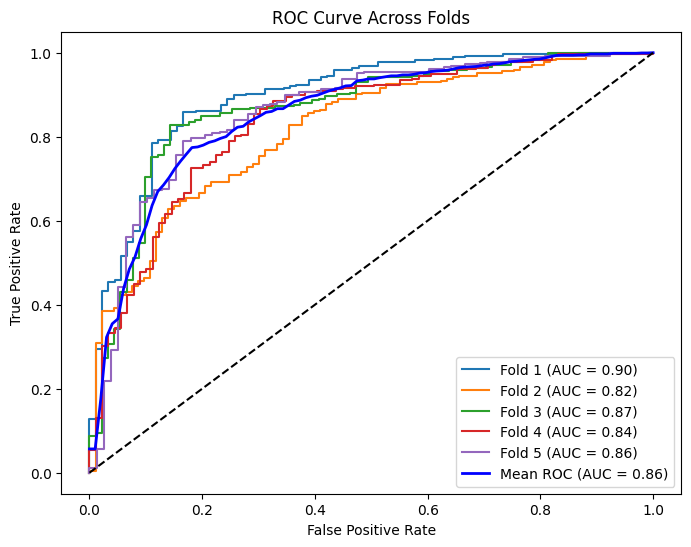

In [22]:
num_features = len(X.columns)
print(f'Training on {num_features} features:\n{X.columns}')

leaky_alpha = 0.05
dropout_ratio = 0.0
# Define the model
def create_model():
    model = keras.Sequential([
        layers.Input((num_features,)),
        layers.Dense(32),
        layers.Dropout(dropout_ratio),
        LeakyReLU(negative_slope=leaky_alpha),
        layers.Dense(16),
        layers.Dropout(dropout_ratio),
        LeakyReLU(negative_slope=leaky_alpha),
        layers.Dense(8),
        layers.Dropout(dropout_ratio),
        LeakyReLU(negative_slope=leaky_alpha),
        layers.Dense(4),
        layers.Dropout(dropout_ratio),
        LeakyReLU(negative_slope=leaky_alpha),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy', 
                  metrics=['AUC'])
    return model

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

accuracies = []
roc_curves = []
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
early_stopping = EarlyStopping(
    mode='max',
    monitor='val_AUC',
    patience=5,
    min_delta=0.01,
    restore_best_weights=True
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y), y=y
)

# Create a dictionary of class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = create_model()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[early_stopping]  # Add EarlyStopping here
    )
    y_pred_prob = model.predict(X_val).flatten()
    
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))
    
    # Interpolate TPR values for mean curve
    interp_tpr = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value=0)(mean_fpr)
    all_tpr.append(interp_tpr)
    
    # Compute accuracy
    test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
    accuracies.append(test_acc)

# Compute mean TPR
mean_tpr = np.mean(all_tpr, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Across Folds')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Create and save submission file
def SaveOutputFilesForCompetition(idx,preds):
    output = pd.DataFrame({'id': idx, target: preds})
    output.to_csv('submission.csv', index=False)

pred_final = model.predict(X_test).flatten()
SaveOutputFilesForCompetition(test_data.index,pred_final)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
